In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install scikeras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from scikeras.wrappers import KerasClassifier

import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T

import os

import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.cm as cm

from sklearn.model_selection import RandomizedSearchCV
from torchvision.models import ResNet18_Weights
import PIL.Image


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!ls

COVID-19_Radiography_Dataset.zip  sample_data


In [3]:
pwd

'/content'

In [8]:
!unzip COVID-19_Radiography_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [9]:
!ls
import shutil

COVID-19_Radiography_Dataset  COVID-19_Radiography_Dataset.zip	sample_data


In [10]:
#Get Data From Zip

!pwd


#Remove Masks in Datasets https://pynative.com/python-delete-files-and-directories/#h-delete-a-non-empty-directory-using-shutil
classes = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']
for i in classes:

  shutil.rmtree(f'/content/COVID-19_Radiography_Dataset/{i}/masks')



/content




s# Keras CNN

In [7]:
train_ds = image_dataset_from_directory(
    directory = '/content/COVID-19_Radiography_Dataset',
    image_size=(256,256),
    batch_size=256,
    seed=42,
    validation_split=0.1,
    shuffle = True,
    subset='training',
)

val_ds = image_dataset_from_directory(
    directory = '/content/COVID-19_Radiography_Dataset',
    image_size=(256,256),
    batch_size=256,
    seed=42,
    validation_split=0.1,
    shuffle = True,
    subset='validation',
)

# tts on training only, use test data as blind

# save model as MODEL object with train data, then load in test data (pickle, keras method)

NotFoundError: ignored

In [ ]:
class_names = train_ds.class_names

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5,5 , i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
model = Sequential()
model.add(Rescaling(1./255,input_shape = (256,256,3)))
model.add(Conv2D(16,3,padding='same',activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same', activation='relu'),)
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same', activation='relu'),)
model.add(MaxPooling2D())
model.add(Dropout(0.35))

model.add(Conv2D(64, 3, padding='same', activation='relu'),)
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128,activation = 'relu',kernel_regularizer = l2(0.001)))
model.add(Dense(4,activation='softmax'))

# Had an error of None,1 not matching None,4, image_from_directory returns the output as a sparse matrix
# credits to https://www.kaggle.com/general/197993
model.compile(optimizer ='adam',loss ='sparse_categorical_crossentropy',metrics =['acc'])

In [ ]:
h = model.fit(train_ds, validation_data = val_ds, epochs=5)

In [ ]:
preds = model.predict(val_ds)

# Pytorch + resnet (res18)

https://pytorch.org/hub/pytorch_vision_resnet/


In [11]:
%matplotlib inline
import random
import torch
import torchvision
from PIL import Image

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.13.1+cu116


In [12]:
# based on pytorch resnet tutorial: https://www.kaggle.com/code/arunmohan003/pytorch-transfer-learning-resnet18

root_dir = "COVID-19_Radiography_Dataset"
source_dirs= ["Normal/images", "Viral Pnemuonia/images", "COVID/images", 'Sick/images']

class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid', 'sick']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = PIL.Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [13]:
train_transform = torchvision.transforms.Compose([
                                                  torchvision.transforms.Resize(size = (300,300)),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  # https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/
                                                  torchvision.transforms.Normalize(mean = [0.485,0.456,0.406], std = [0.229, 0.224, 0.225])
])


test_transform = torchvision.transforms.Compose([
                                                  torchvision.transforms.Resize(size = (300,300)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize([0.485,0.456,0.406], [0.229, 0.224, 0.225])
])

In [14]:
train_dirs = {
    "normal" : "COVID-19_Radiography_Dataset/Normal/images",
    "viral" : "COVID-19_Radiography_Dataset/Viral Pneumonia/images",
    "covid" : "COVID-19_Radiography_Dataset/COVID/images",
    'sick' : "COVID-19_Radiography_Dataset/Lung_Opacity/images"
}
train_dataset = ChestXRayDataset(train_dirs, train_transform)

training_data_size = 0.8

train_size = int(training_data_size * len(train_dataset))
test_size = len(train_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

print("Length of train set   :  ", len(train_dataset))
print("Length of test set    :  ", len(test_dataset))

Found 10192 normal examples
Found 1345 viral examples
Found 3616 covid examples
Found 6012 sick examples
Length of train set   :   16932
Length of test set    :   4233


In [15]:
batch_size = 10

data_train_len = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle = True)
data_test_len = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


print("Length of training batches", len(data_train_len))
print("Lentgth of test batches", len(data_test_len))

Length of training batches 1694
Lentgth of test batches 424


In [16]:
class_names = ["Normal", "Viral Pneumonia","Covid", "Other"]

def show_images(images,labels,preds):
    plt.figure(figsize=(15,7))
    for i , image in enumerate(images):
        plt.subplot(1,11,i+1, xticks = [], yticks= [])
        image = image.numpy().transpose((1,2,0))
        mean = np.array([0.5, 0.5, 0.4])
        std = np.array([0.2, 0.2, 2])
        image = image*std + mean
        image = np.clip(image,0.,1.)
        plt.imshow(image)
        
        colorr = "green"
        if(preds[i] != labels[i]):
            
            colorr="red"
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=colorr)
    plt.tight_layout()
    plt.show()
    
def test_predicts():
    resnet18.eval()
    images, labels = next(iter(data_test_len))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)
        

In [17]:
# https://discuss.pytorch.org/t/name-resnet18-weights-is-not-defined/164063
resnet18 = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
def train(epochs):
    print('Starting training..')

    for e in range(0, epochs):

      # for output
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(data_test_len):
          # torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
            optimizer.zero_grad()
            
            outputs = resnet18(images)

            #https://blog.paperspace.com/pytorch-loss-functions/
            loss = loss_fn(outputs, labels)
            
            #https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(data_test_len):
                    
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                #https://pytorch.org/torcheval/stable/metric_example.html
                print(f'Validation Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}')

                test_predicts()

                resnet18.train()

                if accuracy >= 0.98:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

#        print(f'Training Loss: {train_loss:.4f}')
#    print('Training complete..')

In [19]:

resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)
loss_fn = torch.nn.CrossEntropyLoss()
# https://www.jeremyjordan.me/nn-learning-rate/
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

Starting training..
Starting epoch 1/4
Evaluating at step 0
Validation Loss: 1.4172, Val Accuracy: 0.2993


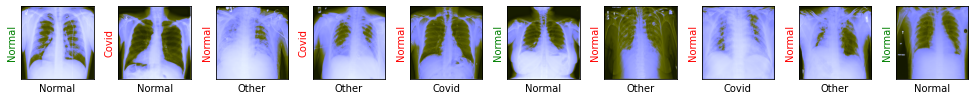

Evaluating at step 20
Validation Loss: 0.9757, Val Accuracy: 0.6558


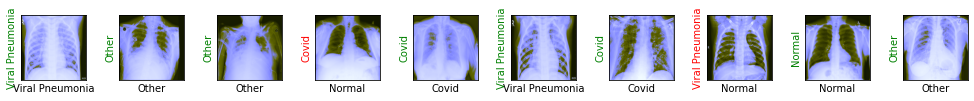

Evaluating at step 40
Validation Loss: 0.6606, Val Accuracy: 0.7680


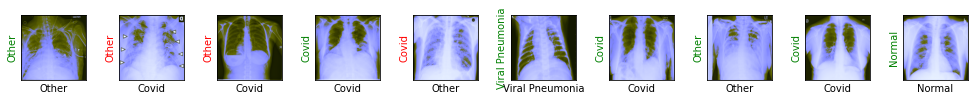

Evaluating at step 60
Validation Loss: 0.4827, Val Accuracy: 0.8441


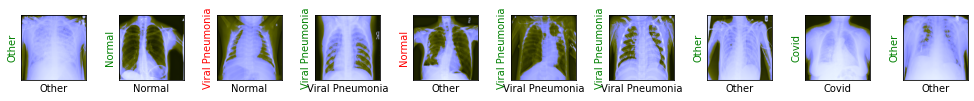

Evaluating at step 80
Validation Loss: 0.4187, Val Accuracy: 0.8559


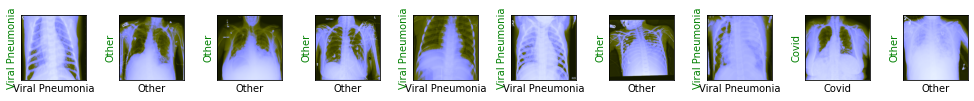

Evaluating at step 100
Validation Loss: 0.3699, Val Accuracy: 0.8786


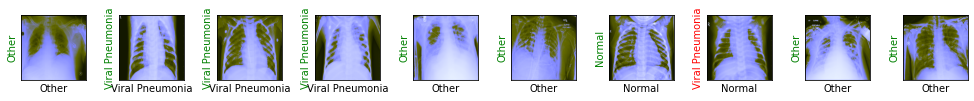

Evaluating at step 120
Validation Loss: 0.3488, Val Accuracy: 0.8831


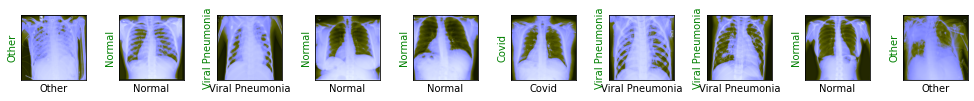

Evaluating at step 140
Validation Loss: 0.3091, Val Accuracy: 0.9005


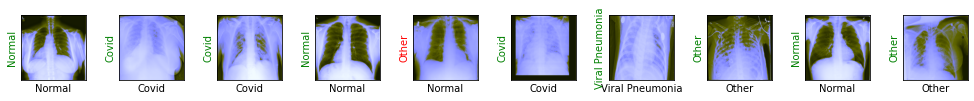

Evaluating at step 160
Validation Loss: 0.2786, Val Accuracy: 0.9062


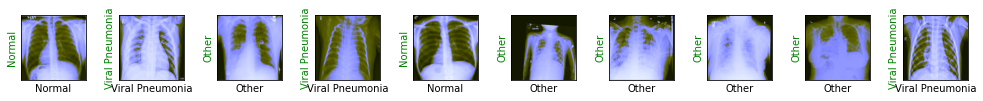

Evaluating at step 180
Validation Loss: 0.2628, Val Accuracy: 0.9128


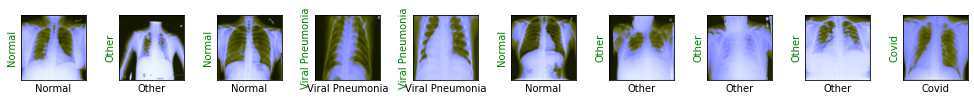

Evaluating at step 200
Validation Loss: 0.2562, Val Accuracy: 0.9116


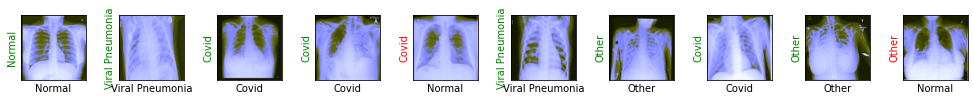

Evaluating at step 220
Validation Loss: 0.2336, Val Accuracy: 0.9284


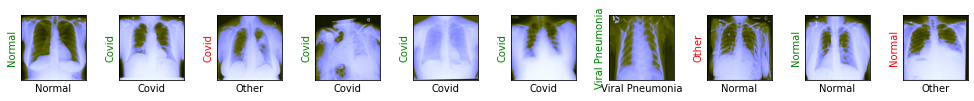

Evaluating at step 240
Validation Loss: 0.2125, Val Accuracy: 0.9289


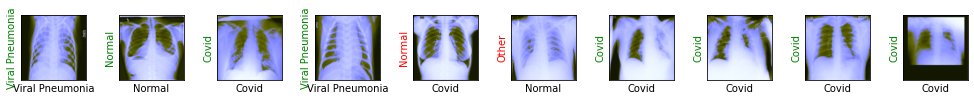

Evaluating at step 260
Validation Loss: 0.2167, Val Accuracy: 0.9294


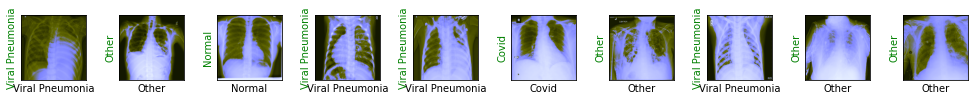

Evaluating at step 280
Validation Loss: 0.2116, Val Accuracy: 0.9313


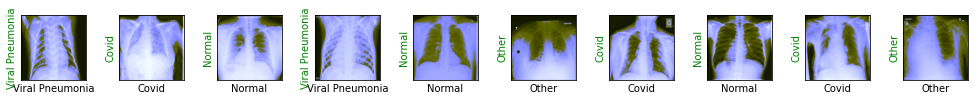

Evaluating at step 300
Validation Loss: 0.2023, Val Accuracy: 0.9346


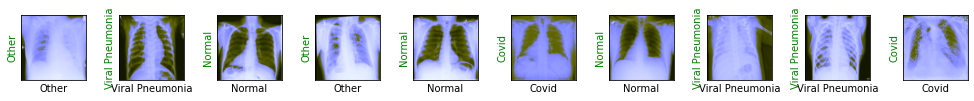

Evaluating at step 320
Validation Loss: 0.1941, Val Accuracy: 0.9400


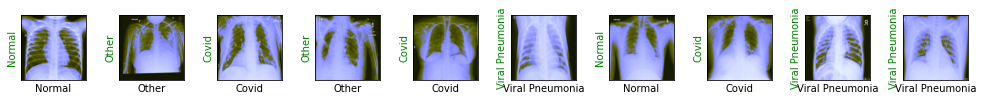

Evaluating at step 340
Validation Loss: 0.2201, Val Accuracy: 0.9246


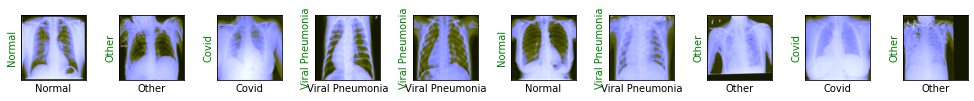

Evaluating at step 360
Validation Loss: 0.2160, Val Accuracy: 0.9320


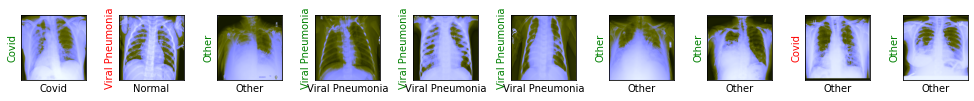

Evaluating at step 380
Validation Loss: 0.1784, Val Accuracy: 0.9409


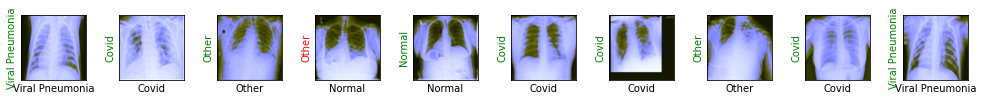

Evaluating at step 400
Validation Loss: 0.1653, Val Accuracy: 0.9468


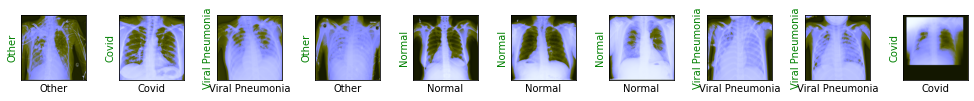

Evaluating at step 420
Validation Loss: 0.1675, Val Accuracy: 0.9440


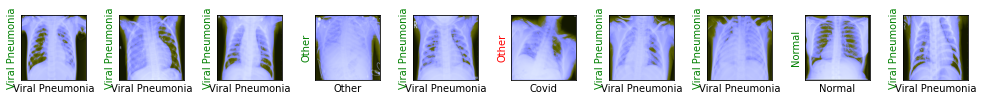

Starting epoch 2/4
Evaluating at step 0
Validation Loss: 0.1618, Val Accuracy: 0.9435


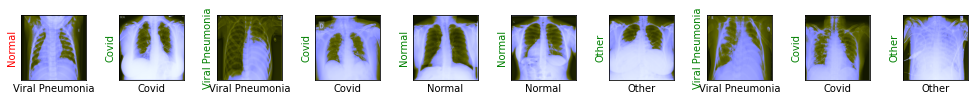

Evaluating at step 20
Validation Loss: 0.1688, Val Accuracy: 0.9393


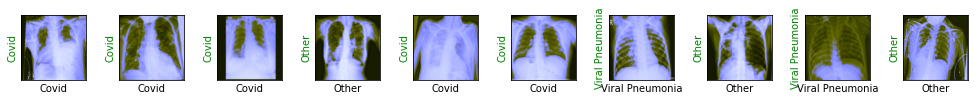

Evaluating at step 40
Validation Loss: 0.1638, Val Accuracy: 0.9480


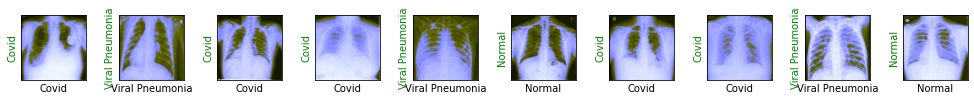

Evaluating at step 60
Validation Loss: 0.1903, Val Accuracy: 0.9317


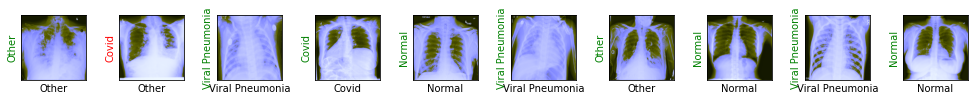

Evaluating at step 80
Validation Loss: 0.1754, Val Accuracy: 0.9412


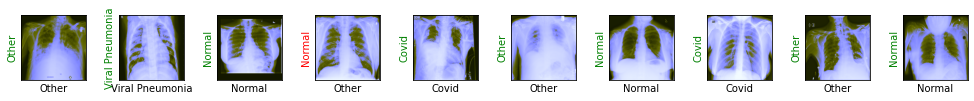

Evaluating at step 100
Validation Loss: 0.1608, Val Accuracy: 0.9499


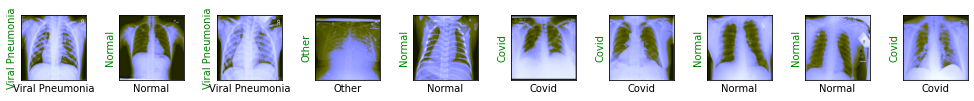

Evaluating at step 120
Validation Loss: 0.1606, Val Accuracy: 0.9497


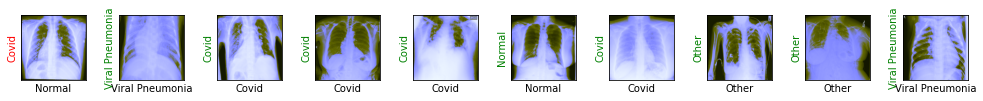

Evaluating at step 140
Validation Loss: 0.1602, Val Accuracy: 0.9499


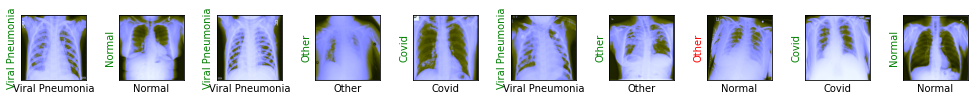

Evaluating at step 160
Validation Loss: 0.1724, Val Accuracy: 0.9433


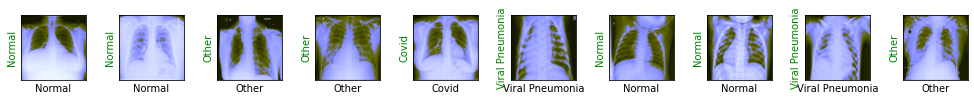

Evaluating at step 180
Validation Loss: 0.1749, Val Accuracy: 0.9421


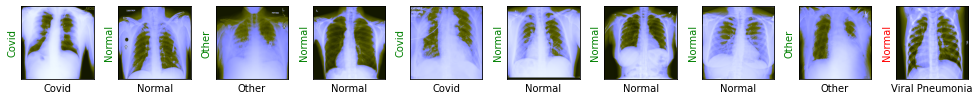

Evaluating at step 200
Validation Loss: 0.1521, Val Accuracy: 0.9466


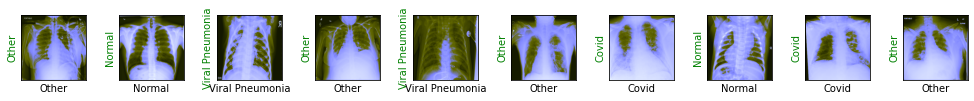

Evaluating at step 220
Validation Loss: 0.1431, Val Accuracy: 0.9525


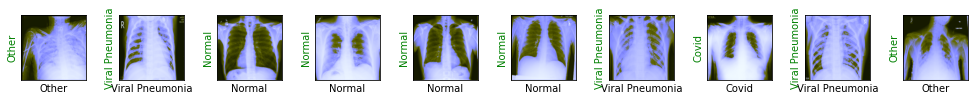

Evaluating at step 240
Validation Loss: 0.1512, Val Accuracy: 0.9513


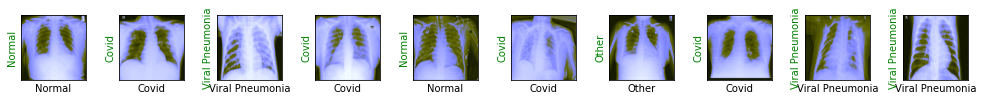

Evaluating at step 260
Validation Loss: 0.1392, Val Accuracy: 0.9516


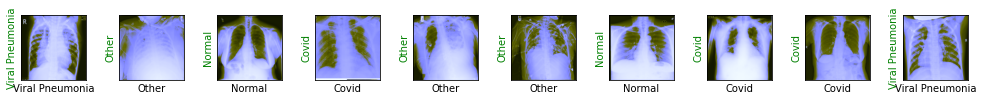

Evaluating at step 280
Validation Loss: 0.1424, Val Accuracy: 0.9509


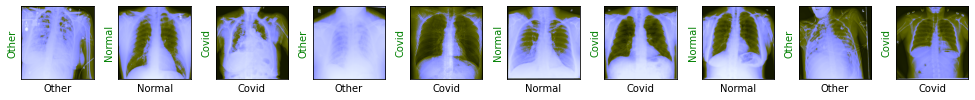

Evaluating at step 300
Validation Loss: 0.1410, Val Accuracy: 0.9532


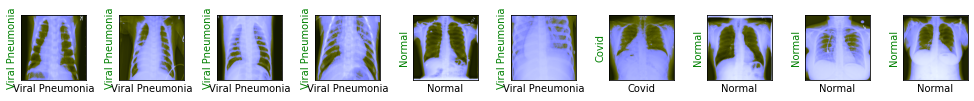

Evaluating at step 320
Validation Loss: 0.1430, Val Accuracy: 0.9570


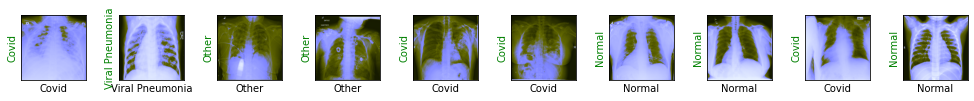

Evaluating at step 340
Validation Loss: 0.1311, Val Accuracy: 0.9575


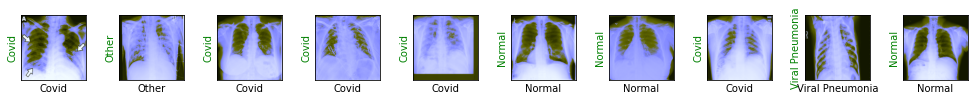

Evaluating at step 360
Validation Loss: 0.1386, Val Accuracy: 0.9530


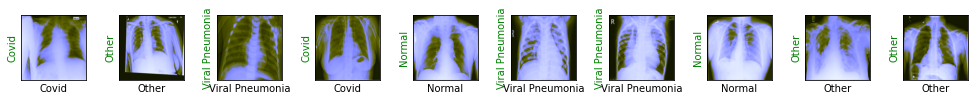

Evaluating at step 380
Validation Loss: 0.1293, Val Accuracy: 0.9544


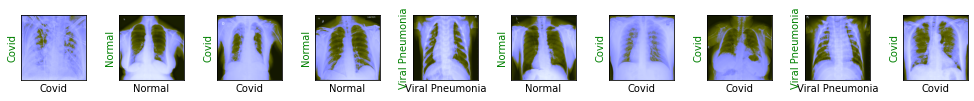

Evaluating at step 400
Validation Loss: 0.1417, Val Accuracy: 0.9570


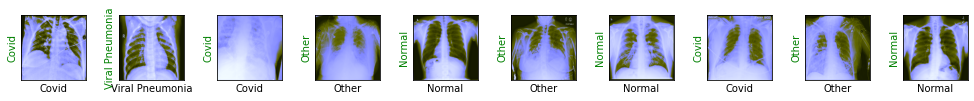

Evaluating at step 420
Validation Loss: 0.1325, Val Accuracy: 0.9577


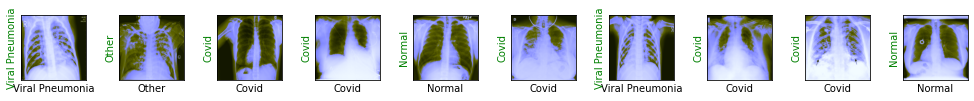

Starting epoch 3/4
Evaluating at step 0
Validation Loss: 0.1447, Val Accuracy: 0.9558


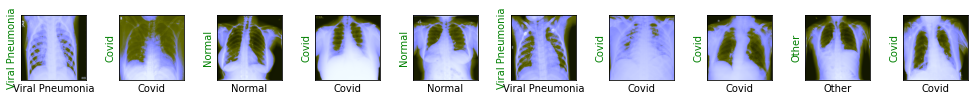

Evaluating at step 20
Validation Loss: 0.1566, Val Accuracy: 0.9483


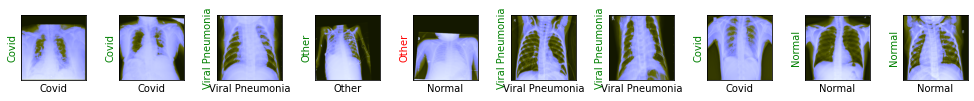

Evaluating at step 40
Validation Loss: 0.1242, Val Accuracy: 0.9617


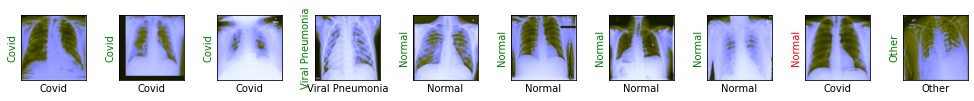

Evaluating at step 60
Validation Loss: 0.1278, Val Accuracy: 0.9613


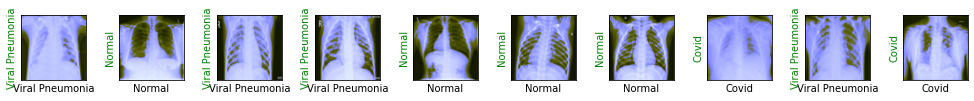

Evaluating at step 80
Validation Loss: 0.1526, Val Accuracy: 0.9483


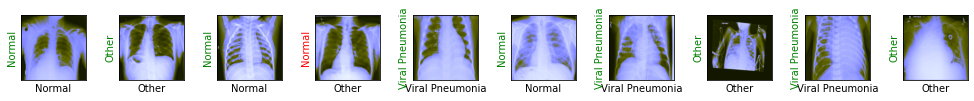

Evaluating at step 100
Validation Loss: 0.1341, Val Accuracy: 0.9605


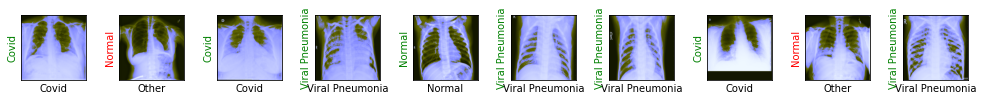

Evaluating at step 120
Validation Loss: 0.1440, Val Accuracy: 0.9466


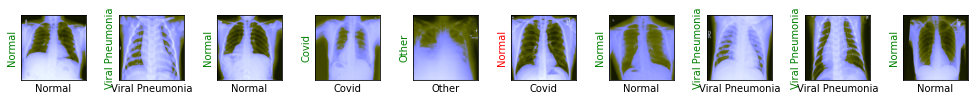

Evaluating at step 140
Validation Loss: 0.1207, Val Accuracy: 0.9620


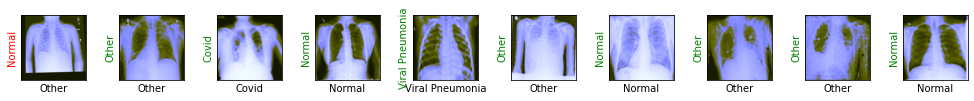

Evaluating at step 160
Validation Loss: 0.1470, Val Accuracy: 0.9509


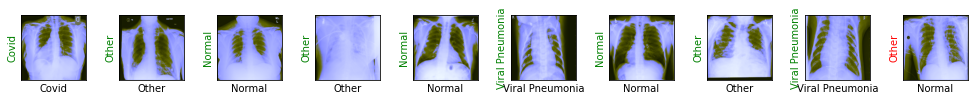

Evaluating at step 180
Validation Loss: 0.1173, Val Accuracy: 0.9624


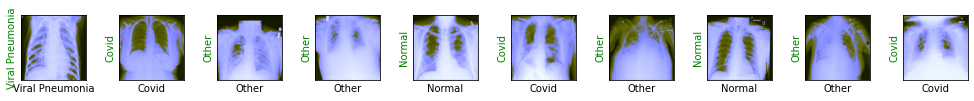

Evaluating at step 200
Validation Loss: 0.1261, Val Accuracy: 0.9587


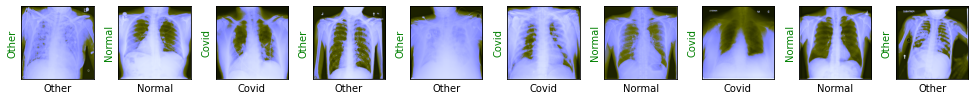

Evaluating at step 220
Validation Loss: 0.1248, Val Accuracy: 0.9598


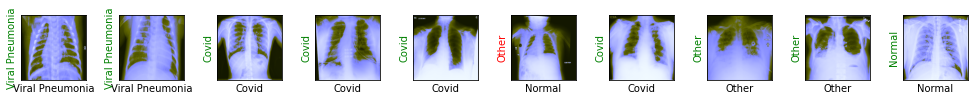

Evaluating at step 240
Validation Loss: 0.1294, Val Accuracy: 0.9539


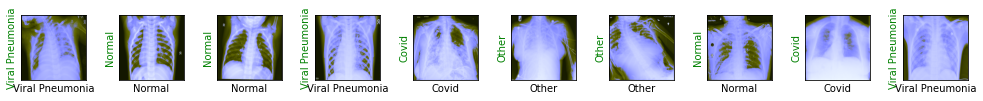

Evaluating at step 260
Validation Loss: 0.1188, Val Accuracy: 0.9584


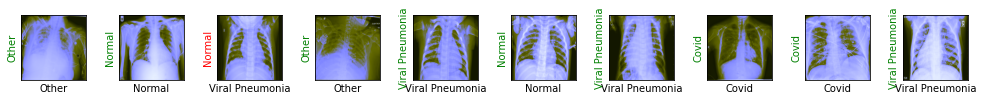

Evaluating at step 280
Validation Loss: 0.1221, Val Accuracy: 0.9579


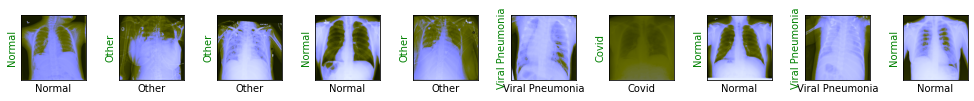

Evaluating at step 300
Validation Loss: 0.1222, Val Accuracy: 0.9591


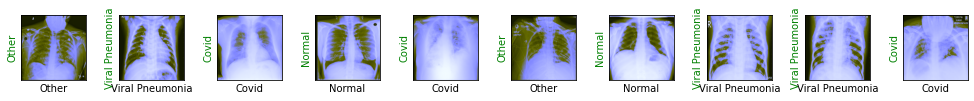

Evaluating at step 320
Validation Loss: 0.1056, Val Accuracy: 0.9669


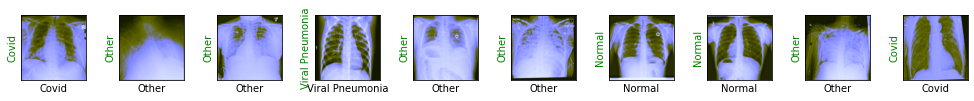

Evaluating at step 340
Validation Loss: 0.1310, Val Accuracy: 0.9591


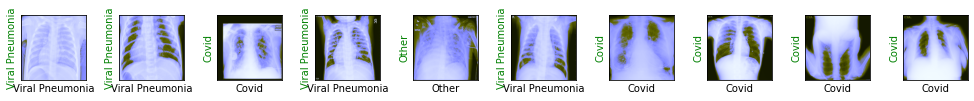

Evaluating at step 360
Validation Loss: 0.1478, Val Accuracy: 0.9473


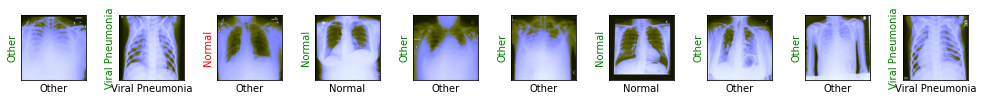

Evaluating at step 380
Validation Loss: 0.1181, Val Accuracy: 0.9639


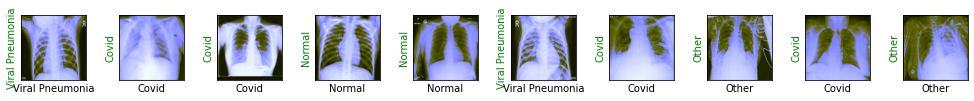

Evaluating at step 400
Validation Loss: 0.1367, Val Accuracy: 0.9506


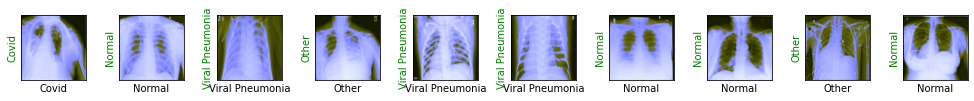

Evaluating at step 420
Validation Loss: 0.1259, Val Accuracy: 0.9565


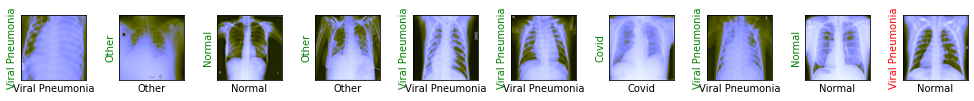

Starting epoch 4/4
Evaluating at step 0
Validation Loss: 0.1257, Val Accuracy: 0.9579


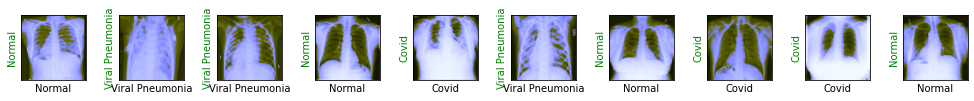

Evaluating at step 20
Validation Loss: 0.1515, Val Accuracy: 0.9468


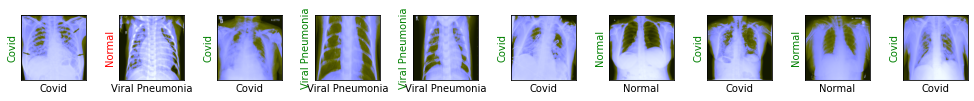

Evaluating at step 40
Validation Loss: 0.1152, Val Accuracy: 0.9634


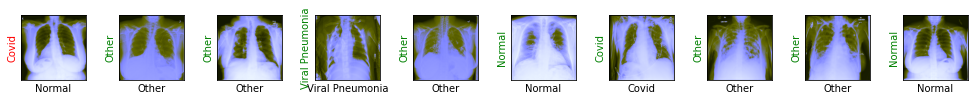

Evaluating at step 60
Validation Loss: 0.1243, Val Accuracy: 0.9608


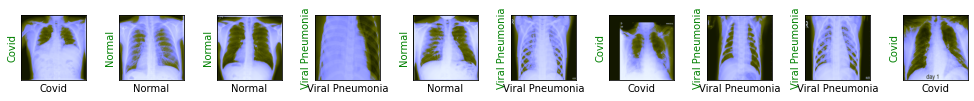

Evaluating at step 80
Validation Loss: 0.1171, Val Accuracy: 0.9608


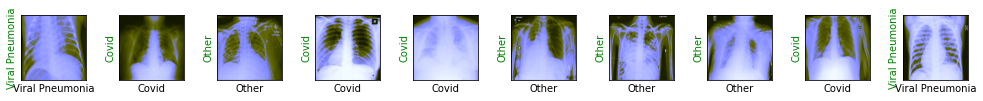

Evaluating at step 100
Validation Loss: 0.1250, Val Accuracy: 0.9601


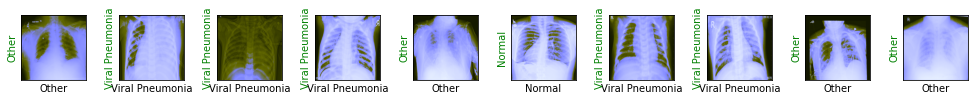

Evaluating at step 120
Validation Loss: 0.1083, Val Accuracy: 0.9646


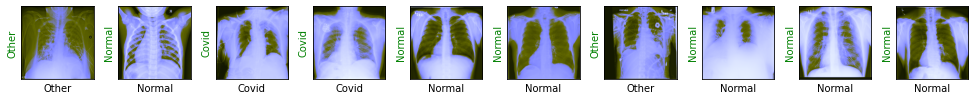

Evaluating at step 140
Validation Loss: 0.1064, Val Accuracy: 0.9629


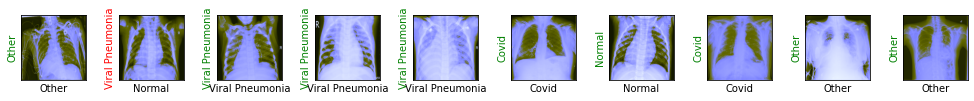

Evaluating at step 160
Validation Loss: 0.1189, Val Accuracy: 0.9577


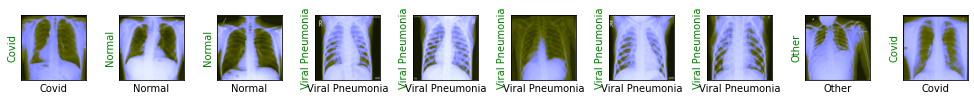

Evaluating at step 180
Validation Loss: 0.1055, Val Accuracy: 0.9650


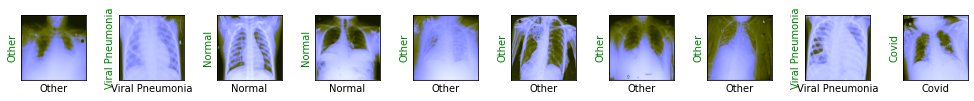

Evaluating at step 200
Validation Loss: 0.0995, Val Accuracy: 0.9674


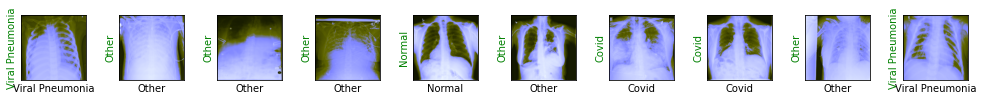

Evaluating at step 220
Validation Loss: 0.1012, Val Accuracy: 0.9674


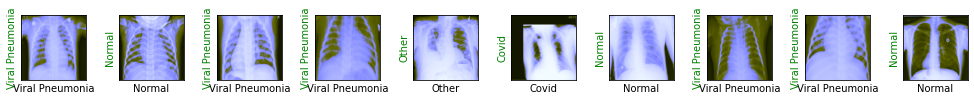

Evaluating at step 240
Validation Loss: 0.1151, Val Accuracy: 0.9577


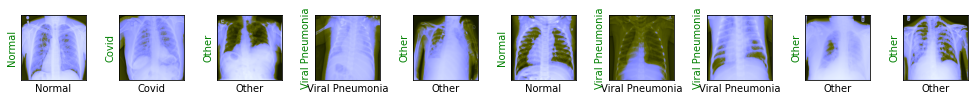

Evaluating at step 260
Validation Loss: 0.0985, Val Accuracy: 0.9691


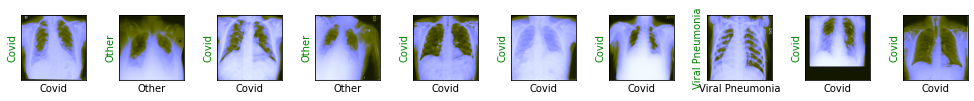

Evaluating at step 280
Validation Loss: 0.0879, Val Accuracy: 0.9724


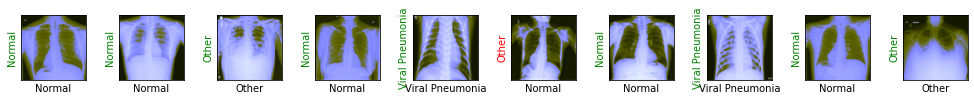

Evaluating at step 300
Validation Loss: 0.1042, Val Accuracy: 0.9669


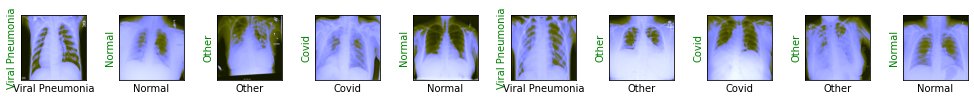

Evaluating at step 320
Validation Loss: 0.1034, Val Accuracy: 0.9643


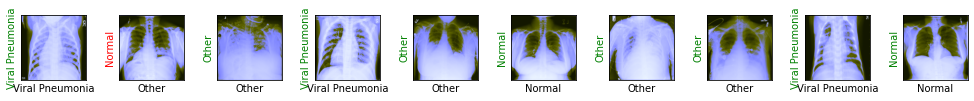

Evaluating at step 340
Validation Loss: 0.0996, Val Accuracy: 0.9641


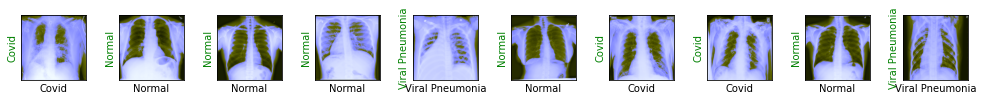

Evaluating at step 360
Validation Loss: 0.1044, Val Accuracy: 0.9627


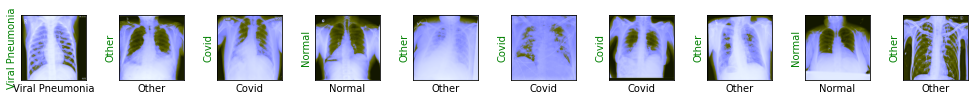

Evaluating at step 380
Validation Loss: 0.1049, Val Accuracy: 0.9679


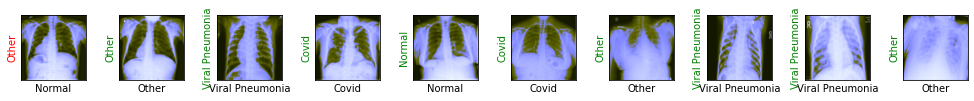

Evaluating at step 400
Validation Loss: 0.1509, Val Accuracy: 0.9466


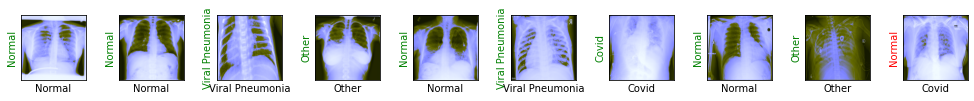

Evaluating at step 420
Validation Loss: 0.1045, Val Accuracy: 0.9669


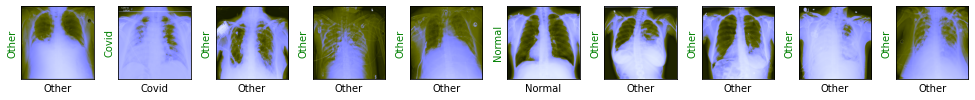

In [20]:
train(epochs = 4)

In [21]:
# https://discuss.pytorch.org/t/how-does-one-get-the-predicted-classification-label-from-a-pytorch-model/91649/2



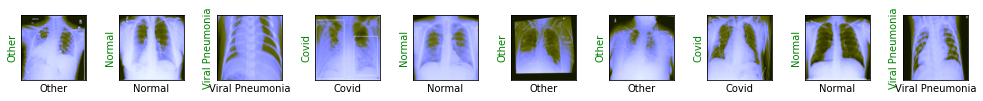

In [23]:
test_predicts()